# Defacing pre-registration - Statistical analysis in R

## Load simulated or collected manual ratings

In [37]:
# Load ratings
df <- read.csv("../../data/IXI_augmented_ratings_df.tsv", sep="\t")
df

rater_id,dataset,randomized_id,rating,artifacts,time_sec,confidence,comments,defaced,subject
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>
rater_02,IXI dataset - MRIQC derivatives,sub-0152_T1w,2.45,"[""noise-global"",""processing"",""uncategorized""]",255.737,2.65,"Image blurry, smooth, Slight drop out in frontal",1,72
rater_02,IXI dataset - MRIQC derivatives,sub-0152_T1w,2.55,"[""noise-global"",""inu"",""processing"",""uncategorized""]",58.812,2.50,"blurry, smooth image, A bit of signal dropout in frontal",1,72
rater_02,IXI dataset - MRIQC derivatives,sub-1051_T1w,2.85,"[""noise-local"",""processing""]",150.737,3.50,Smooth. but seems to be the case of most of the images of the dataset,0,354
rater_02,IXI dataset - MRIQC derivatives,sub-1186_T1w,2.55,"[""wrap-around"",""uncategorized""]",104.950,3.35,"Slightly short FoV in frontal, bordeline cutting the cortex, Small artefact in the background",0,205
rater_02,IXI dataset - MRIQC derivatives,sub-0951_T1w,3.45,"[""inu""]",84.569,3.50,,1,446
rater_02,IXI dataset - MRIQC derivatives,sub-0902_T1w,2.95,"[""processing""]",68.889,3.50,,1,248
rater_02,IXI dataset - MRIQC derivatives,sub-0250_T1w,2.55,"[""uncategorized""]",90.318,3.15,looks like a bit of drop out in frontal and a bit of background artefact,0,437
rater_02,IXI dataset - MRIQC derivatives,sub-0394_T1w,2.95,"[""wrap-around"",""processing""]",97.632,1.95,FoV cut a bit short in frontal,1,600
rater_02,IXI dataset - MRIQC derivatives,sub-0924_T1w,2.60,"[""noise-local"",""inu"",""processing""]",79.662,3.50,,0,614


Let us verify that each rater rated all 450 images.

In [38]:
raters <- list('rater_01', 'rater_02', 'rater_03', 'rater_04')
for (rater in raters) {
  df_rater <- subset(df, rater_id == rater)
  # If an image was assigned several ratings by the same rater, we keep only the last one
  df_unique <- df_rater[!duplicated(df_rater[c("rater_id", "randomized_id")], fromLast = TRUE), ]
  print(paste(rater, ":", nrow(df_unique), "images rated"))
}

[1] "rater_01 : 450 images rated"
[1] "rater_02 : 450 images rated"
[1] "rater_03 : 450 images rated"
[1] "rater_04 : 450 images rated"


### Plot ratings distribution

To explore whether a bias is visible in the data, we plot for each rater the distribution of the ratings extracted from non-defaced versus defaced images.

In [39]:
# Convert defaced to factor for better visualization
df$defaced <- factor(df$defaced, levels = c(0, 1), labels = c("Non-defaced", "Defaced"))

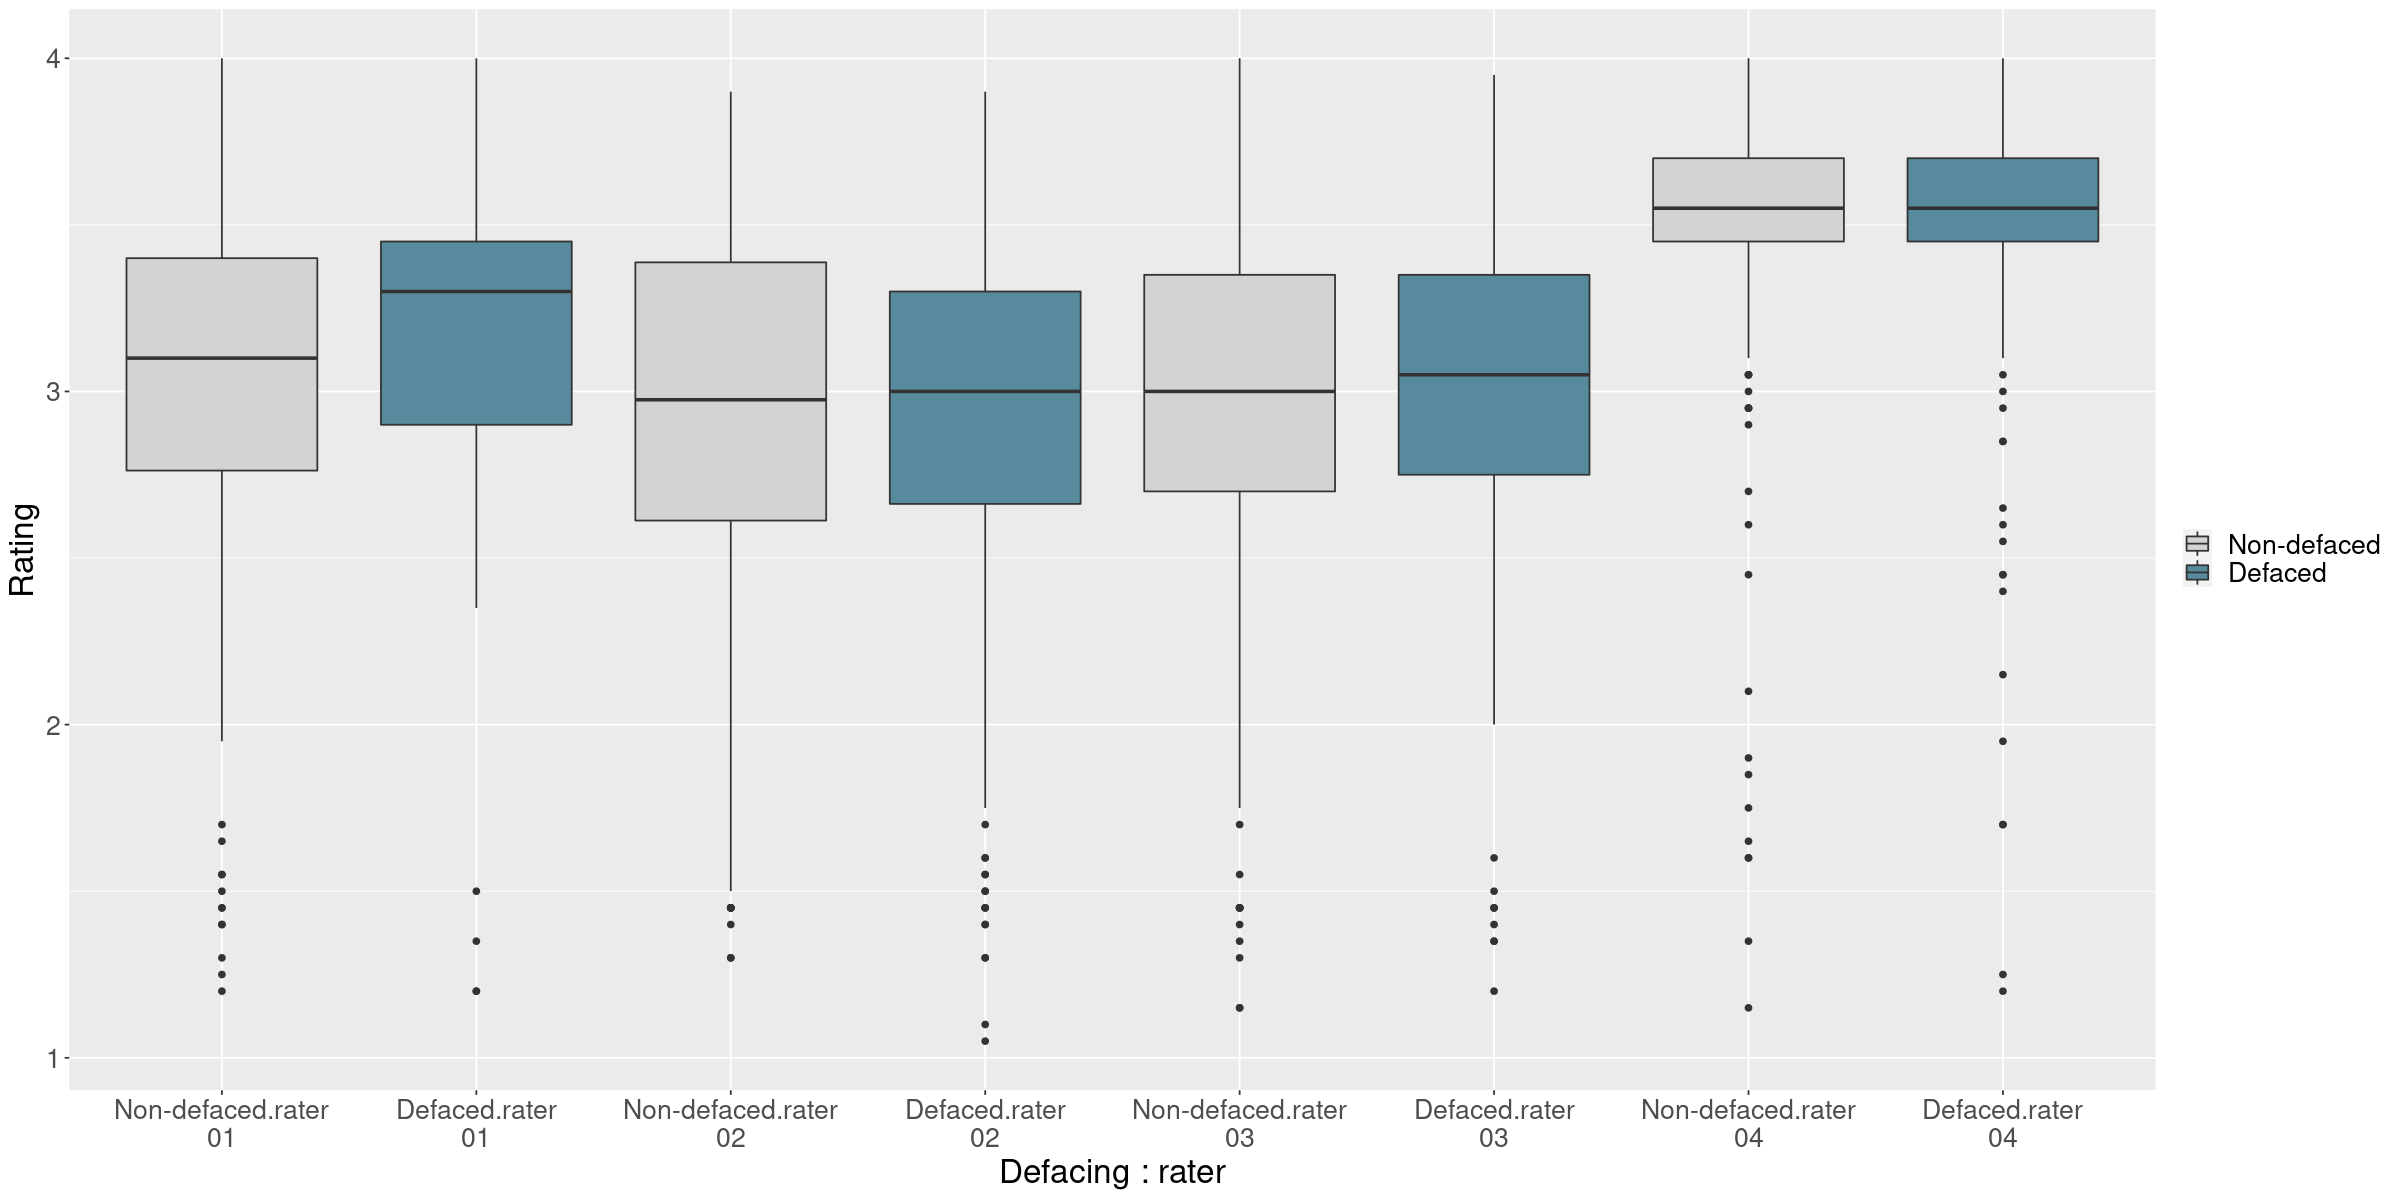

In [40]:
#change size of displayed plot
library(ggplot2)
#Increase plot size
options(repr.plot.width=20, repr.plot.height=10)

# Create boxplot
ggplot(df, aes(x = interaction(defaced, rater_id), y = rating, fill = defaced)) +
  geom_boxplot(position = position_dodge(0.8)) +
  scale_x_discrete(labels = function(x) gsub("_", "\n", x)) +
  labs(x = "Defacing : rater", y = "Rating", fill = "Defacement") +
  theme(text = element_text(size = 20)) +
  scale_fill_manual(values = c("Non-defaced" = "lightgrey", "Defaced" = "#578a9c")) +
  theme(legend.title = element_blank()) +
  theme(legend.position = "right")

It is interesting to see that different raters present a bias of different magnitude, our most expert rater is the one being most biased by the defacing process. It is also interesting to note that rater_04 was overall more optimistic about the images quality. Let us now perform statistical test to see whether the impact of defacing on the quality score is significant.

## Repeated-measures ANOVA

### Check assumptions

Repeated-measures ANOVA makes the following three assumptions on the data :
1. **No significant outlier** : By construction the ratings cannot leave the range we define, so this assumption is granted
2. **Normality** : we will have many ratings so by the central theorem this assumption should be ok
3. **Sphericity** : the variance of the differences between groups should be equal.

In [41]:
##Test for normality
library(ggpubr)
shapiro.test(df$rating)


	Shapiro-Wilk normality test

data:  df$rating
W = 0.90688, p-value < 2.2e-16


The Shapiro-Wilk normality test reveals that the data are not normally distributed, let us double-check the non-normality using a Q-Q plot.

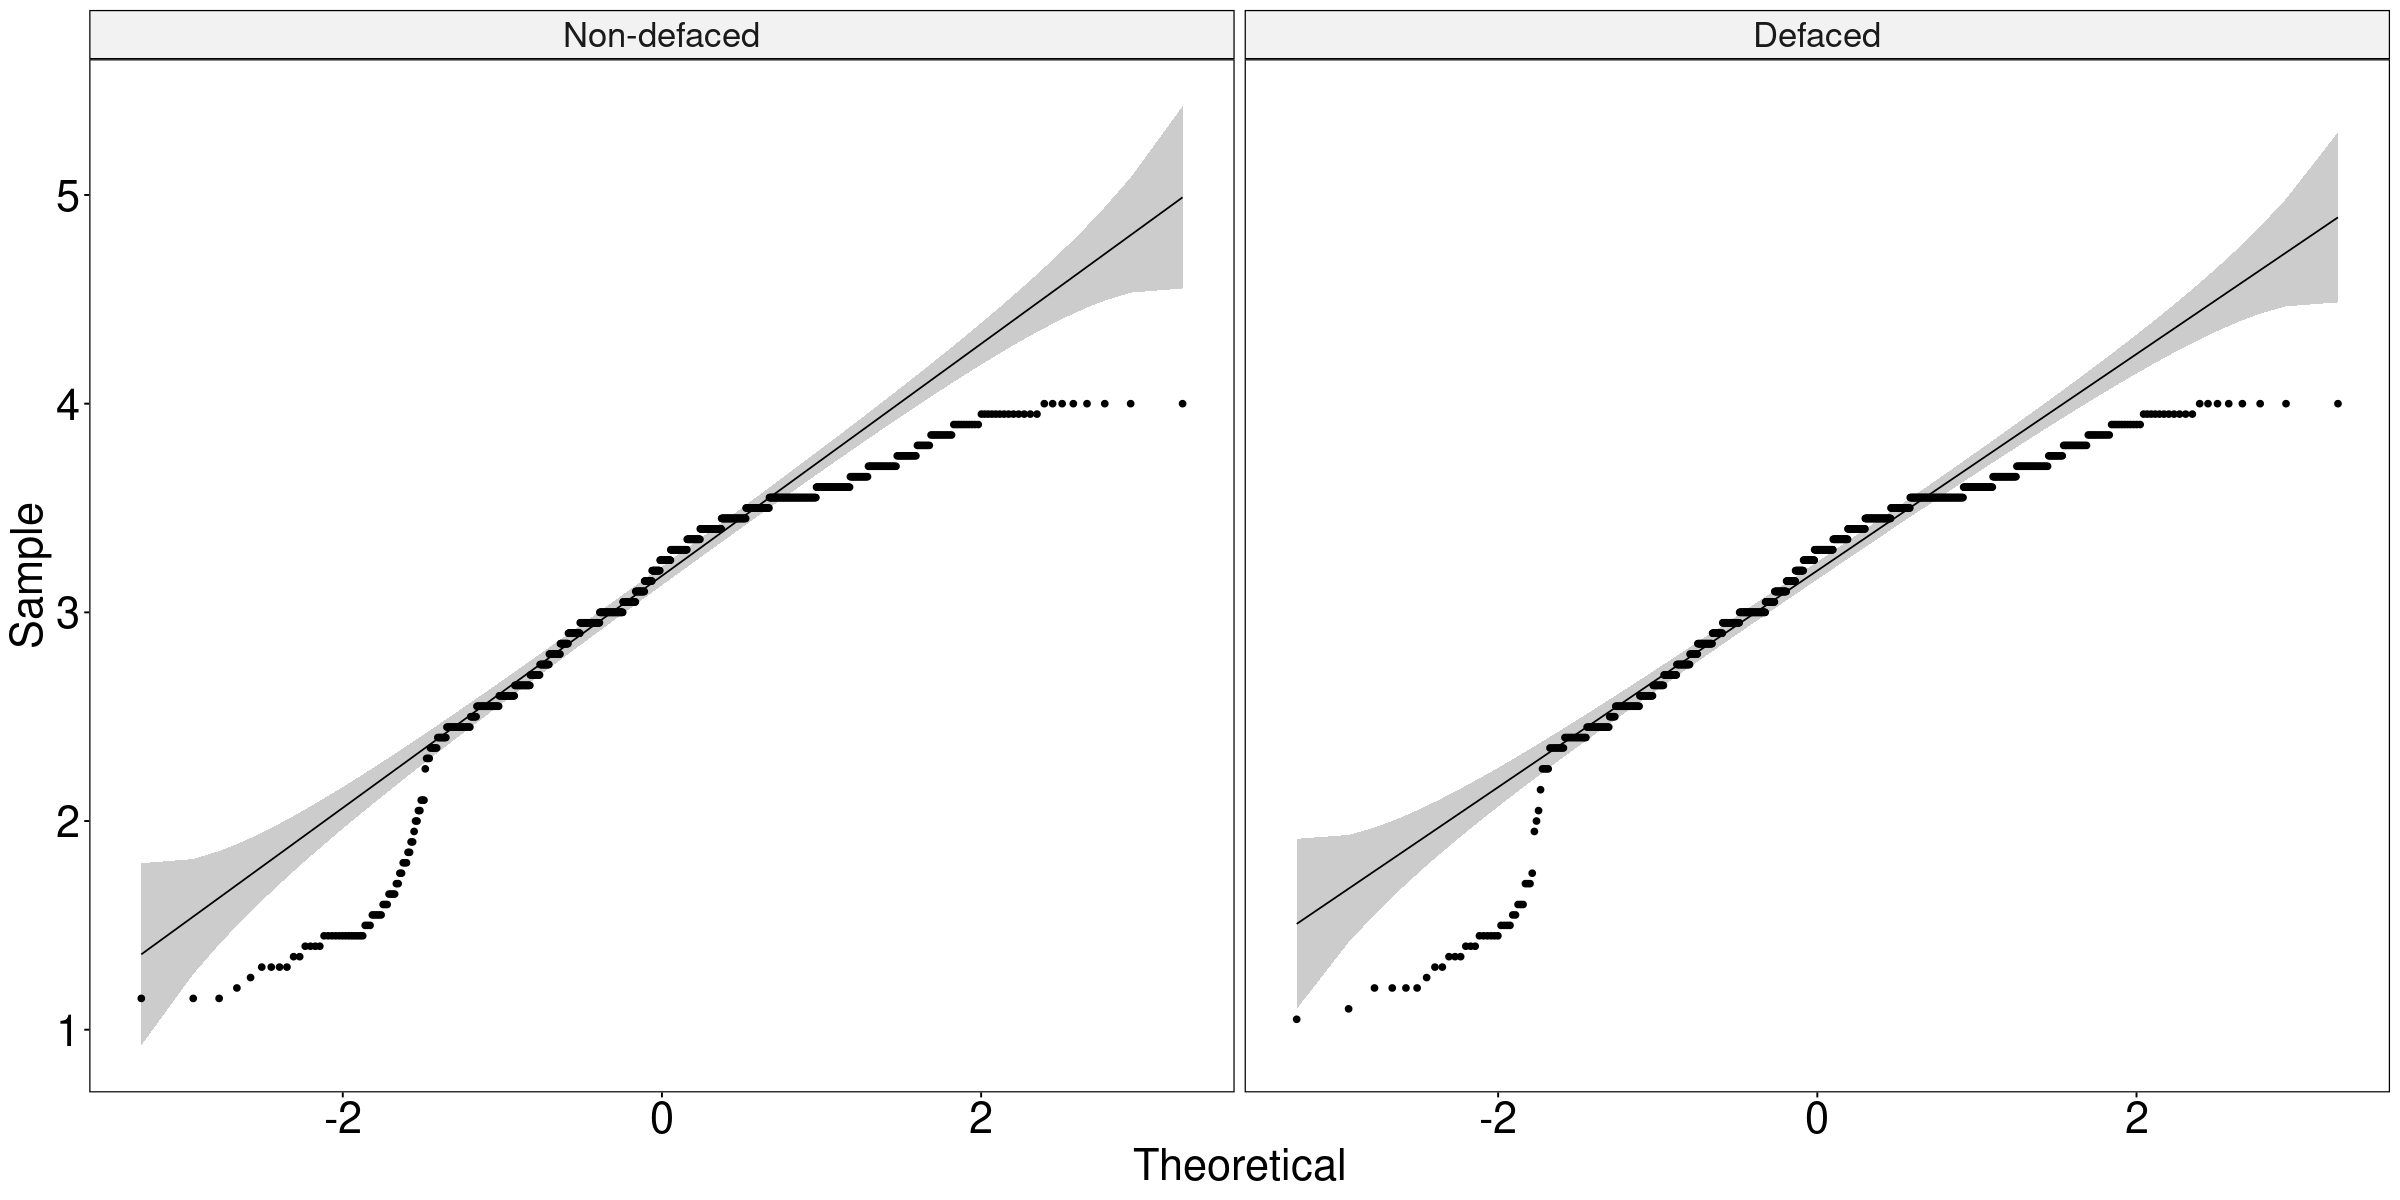

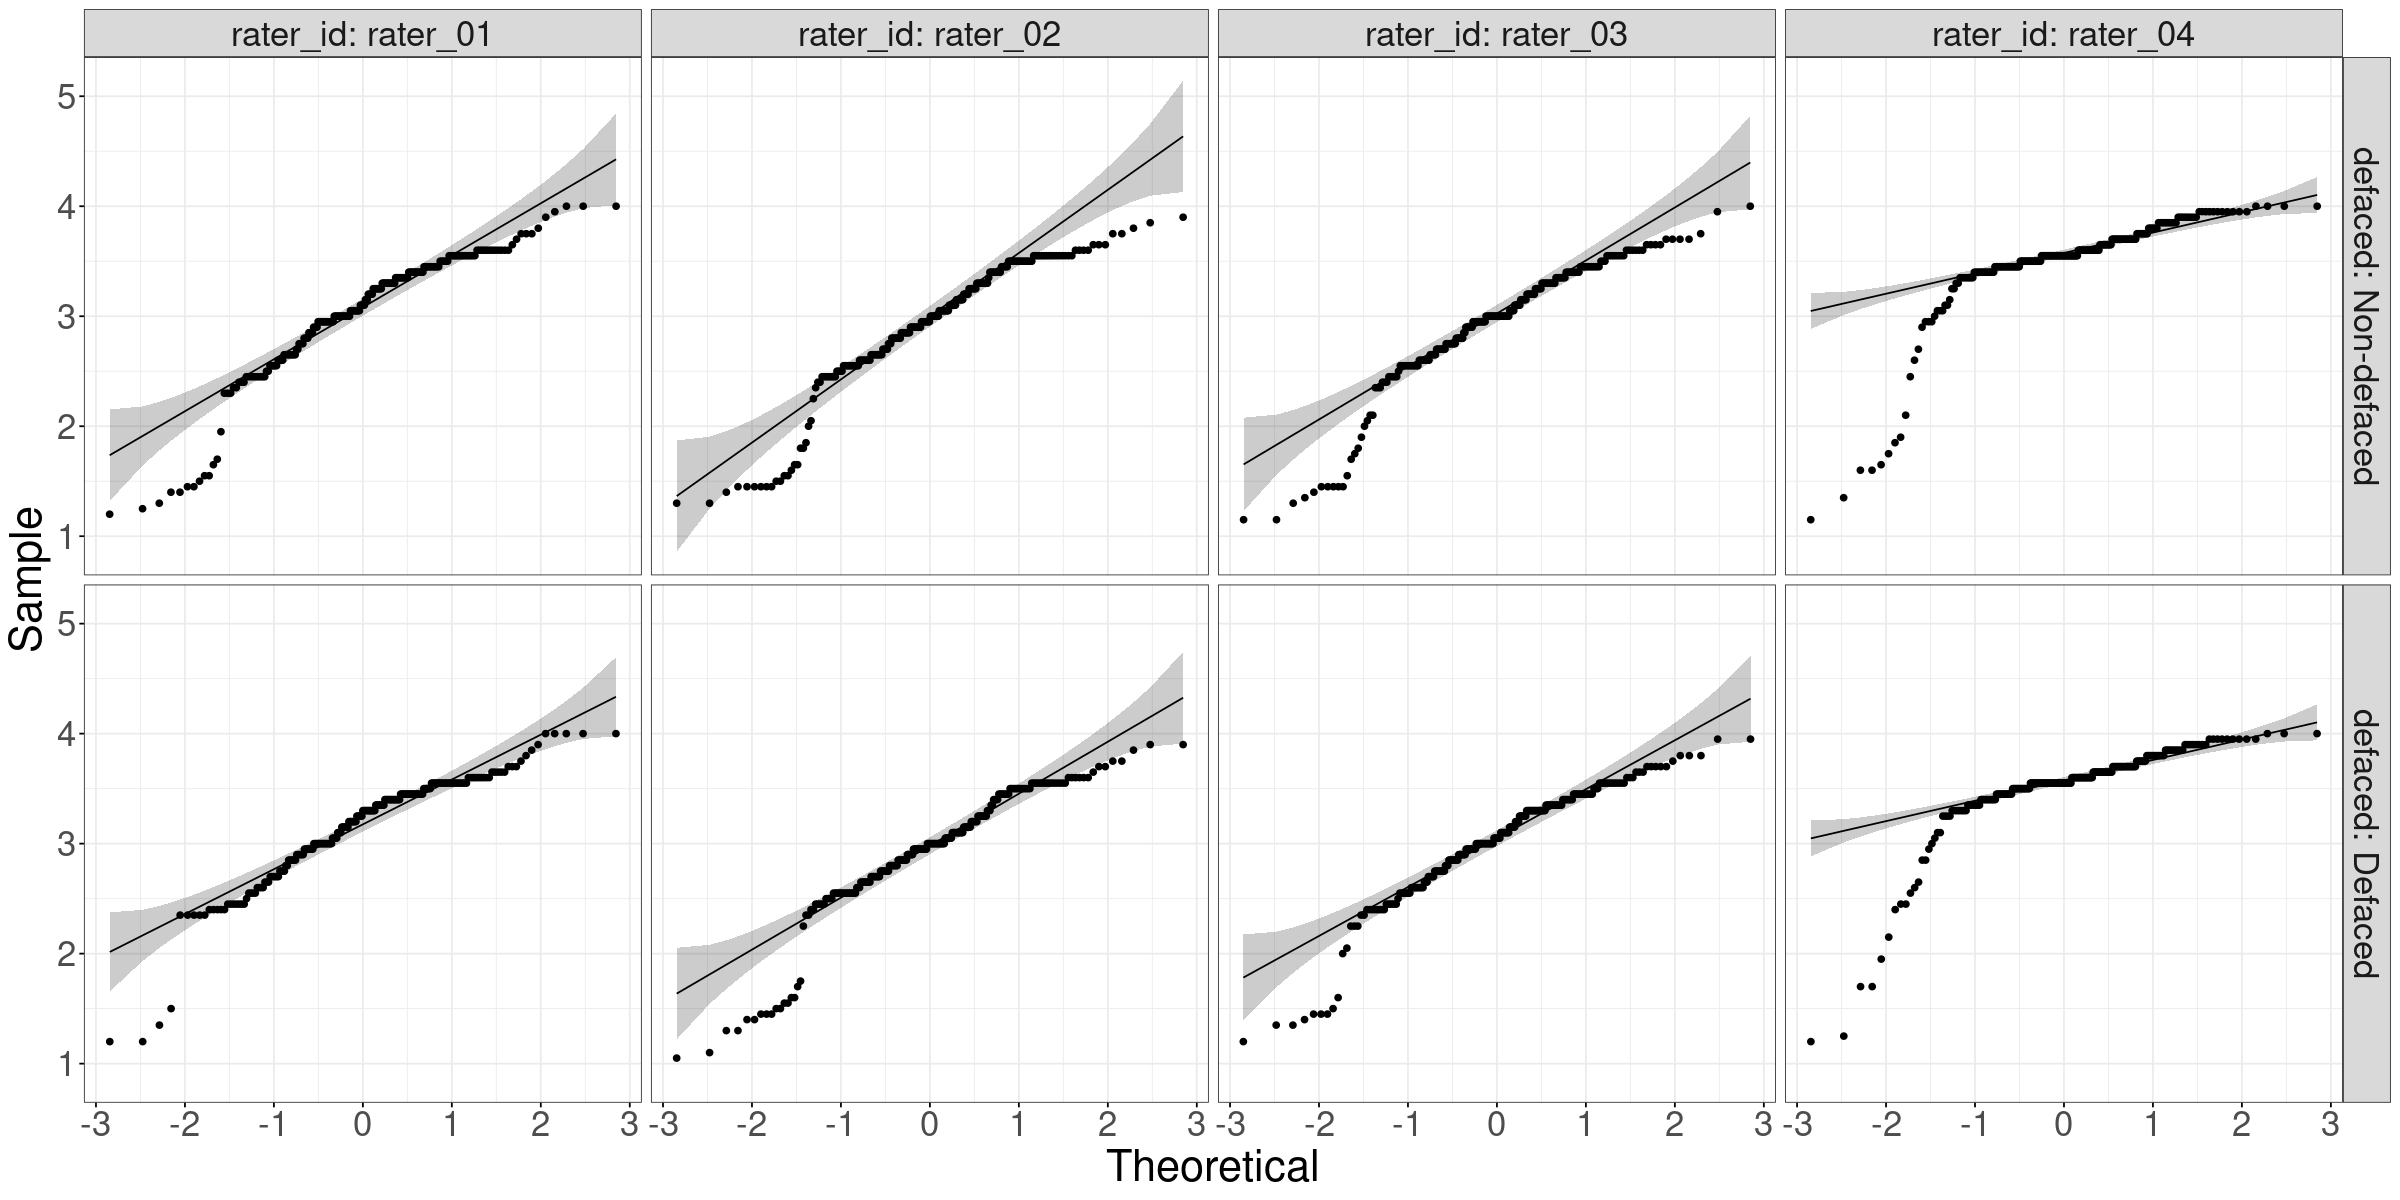

In [45]:
## Other test for normality
ggqqplot(df, "rating", facet.by = 'defaced') +
  theme(text = element_text(size = 26))
ggqqplot(df, "rating", ggtheme = theme_bw()) +
  facet_grid(defaced ~ rater_id, labeller = "label_both") +
  theme(text = element_text(size = 26))

The ratings do not fall on the reference line confirming that they are not normally distributed. This non-normality applies whether the ratings are pooled or separated across raters. This indicated that the ratings at hand do not respect the normality assumption of ANOVA, as such we cannot use this test and we will have to use the linear mixed effects models.

### The rest of the notebook is presented for legacy but was not run on the ratings from the IXI dataset, as the violation of the normality assumption prevents applying rm-ANOVA.

In [ ]:
## Test for sphericity
library(rstatix)
suppressWarnings(anova_test(data = df, dv = rating, wid= randomized_id, within = c(defaced, rater_id)))

For the assumption of sphericity to be verified, the test should not reject the null hypothesis, which is that the variance between group is equal. If any assumption is violated, we will switch to the alternative analysis using linear mixed-effects models.

### Run ANOVA

In [ ]:
suppressWarnings(res.aov <- anova_test(data = df, dv = rating, wid = subject, within = c(defaced, rater_id)))
get_anova_table(res.aov)

### Verify that the null hypothesis is not rejected if no bias has been introduced

In [ ]:
#Define for each rater the percentage of biased ratings
perc_biased <- c(10,10,10,10)
bias <- 1

df_nobias <- simulate_normal_data(n_rated, n_sub, n_rater, perc_biased, mean=mean, sd=sd, bias=bias)
df_nobias$ratings <- as.numeric(df_nobias$ratings)

## Lmer should not find significant result
suppressWarnings(res.aov <- anova_test(data = df_nobias, dv = ratings, wid = sub, within = c(defaced, rater)))
get_anova_table(res.aov)

## Friedman test

Non-parametric alternative to repeated-measure ANOVA.

In [ ]:
friedman.test(y=df$ratings, groups=factor(df$defaced), blocks=factor(df$sub))

Cannot use this function : An unreplicated complete block design has exactly 1 observation for each combination of the two grouping factors. But we have 4 observations of the combination defaced + sub 1 : rater01,02,03,04.